## Data Imports

In [2]:
## Link: https://github.com/WJMatthew/WESAD/blob/master/data_wrangling.py
import os
import re
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import scipy.signal as scisig
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib as mpl
import heartpy as hp
import biosppy
import neurokit2 as nk
from heartpy.datautils import *
from heartpy.peakdetection import *
mpl.rcParams['agg.path.chunksize'] = 10000
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report

# Feature Extraction

## Parameters

In [113]:
# E4 (wrist) Sampling Frequencies
fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 700, 'Resp': 700, 'ECG': 700, 
           'chest': 700}
# Window size
WINDOW_IN_SECONDS = 30

# Labels
label_dict = {'baseline': 1, 'stress': 2, 'amusement': 0}
# Int to label mappings
int_to_label = {1: 'baseline', 2: 'stress', 0: 'amusement'}
# Feature names
feat_names = None
# Where to save the data
savePath = 'data'
# Where to get the data
subject_feature_path = '/subject_feats'

if not os.path.exists(savePath):
    os.makedirs(savePath)
if not os.path.exists(savePath + subject_feature_path):
    os.makedirs(savePath + subject_feature_path)

## Class to Store Subject Data

In [114]:
# Class to store the data for each subject
class SubjectData:

    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']

    def get_wrist_data(self):
        data = self.data['signal']['wrist']
        data.update({'ACC_C': self.data['signal']['chest']['ACC'],
                     'ECG_C': self.data['signal']['chest']['ECG'],
                     'EDA_C': self.data['signal']['chest']['EDA'],
                     'EMG_C': self.data['signal']['chest']['EMG'],
                     'Resp_C': self.data['signal']['chest']['Resp'],
                     'Temp_C': self.data['signal']['chest']['Temp']
                     })
        return data

    def get_chest_data(self):
        return self.data['signal']['chest']

    def extract_features(self):  # only wrist
        results = \
            {
                key: get_statistics(self.get_wrist_data()[key].flatten(), self.labels, key)
                for key in self.wrist_keys
            }
        return results

## EDA

In [115]:
# cvxEDA
# def eda_stats(y):
#     Fs = fs_dict['EDA']
#     yn = (y - y.mean()) / y.std()
#     [r, p, t, l, d, e, obj] = cvxEDA.cvxEDA(yn, 1. / Fs)
#     return [r, p, t, l, d, e, obj]

## ACC

In [116]:
def get_net_accel(data):
    return (data['ACC_x'] ** 2 + data['ACC_y'] ** 2 + data['ACC_z'] ** 2).apply(lambda x: np.sqrt(x))

In [117]:
def get_net_accel_C(data):
    return (data['ACC_x'] ** 2 + data['ACC_y'] ** 2 + data['ACC_z'] ** 2).apply(lambda x: np.sqrt(x))

## Helper Functions

### Lowpass

In [118]:
# https://github.com/MITMediaLabAffectiveComputing/eda-explorer/blob/master/load_files.py
def butter_lowpass(cutoff, fs, order=5):
    # Filtering Helper functions
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scisig.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

### Lowpass Filter

In [119]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    # Filtering Helper functions
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = scisig.lfilter(b, a, data)
    return y

### Slope Calculator

In [120]:
def get_slope(series):
    linreg = scipy.stats.linregress(np.arange(len(series)), series )
    slope = linreg[0]
    return slope

### Mean/Std/Min/Max

In [121]:
def get_window_stats(data, label=-1):
    mean_features = np.mean(data)
    std_features = np.std(data)
    min_features = np.amin(data)
    max_features = np.amax(data)

    features = {'mean': mean_features, 'std': std_features, 'min': min_features, 'max': max_features,
                'label': label}
    return features

### Absolute Integral

In [122]:
def get_absolute_integral(x):
    return np.sum(np.abs(x))

### Dynamic Range

In [123]:
def get_dynamic_range(x):
    return np.max(x) / np.min(x)

### Peak Frequency (Periodogram)

In [124]:
def get_peak_freq(x):
    f, Pxx = scisig.periodogram(x, fs=8)
    psd_dict = {amp: freq for amp, freq in zip(Pxx, f)}
    peak_freq = psd_dict[max(psd_dict.keys())]
    return peak_freq

### Respiration Features

In [125]:
def get_resp_features(resp_data):
    resp_rate, filtered, zeros, resp_rate_ts, resp_rate = biosppy.signals.resp.resp(resp_data, sampling_rate=700, show=False)
    extremas, values = biosppy.signals.tools.find_extrema(signal=filtered, mode='both')
    inhal_durations = []
    exhal_durations = []
    last_index = 0
    for i in range(len(extremas)):
        if values[i] * values[last_index] < 0:
            if values[last_index] < 0:
                inhal_durations.append((extremas[i] - extremas[last_index]) / 700)
            else:
                exhal_durations.append((extremas[i] - extremas[last_index]) / 700)
            last_index = i
    return np.mean(resp_rate), np.mean(inhal_durations), np.std(inhal_durations), np.mean(exhal_durations), np.std(exhal_durations), np.sum(inhal_durations) / np.sum(exhal_durations)

### FIR Filter

In [126]:
# https://github.com/MITMediaLabAffectiveComputing/eda-explorer/blob/master/AccelerometerFeatureExtractionScript.py
def filterSignalFIR(eda, cutoff=0.4, numtaps=64):
    f = cutoff / (fs_dict['ACC'] / 2.0)
    FIR_coeff = scisig.firwin(numtaps, f)

    return scisig.lfilter(FIR_coeff, 1, eda)

## ECG

In [132]:
# Calculating window statistics for ECGs
def get_window_stats_ecg(data, label=-1):
    wd, m = hp.process(data['ECG'].dropna().reset_index(drop=True), 700)
    return {'bpm': m['bpm'], 'ibi': m['ibi'], 'sdnn': m['sdnn'], 'sdsd': m['sdsd'], 
            'rmssd': m['rmssd'], 'pnn20': m['pnn20'], 'pnn50': m['pnn50']}

In [133]:
def compute_features_chest(ch_data_dict, labels, norm_type=None):
    ecg_df = pd.DataFrame(ch_data_dict['ECG'], columns=['ECG'])
    
    # Adding index for combination due to different sampling frequencies
    ecg_df.index = [(1 / fs_dict['ECG']) * i for i in range(len(ecg_df))]
    
    # Change index to datetime
    ecg_df.index = pd.to_datetime(ecg_df.index, unit='s')
    
    return ecg_df

## Compute Features

In [134]:
# Computes features for wrist
def compute_features(e4_data_dict, ch_data_dict, labels, norm_type=None):
    # Dataframes for each sensor type
    eda_df = pd.DataFrame(e4_data_dict['EDA'], columns=['EDA'])
    bvp_df = pd.DataFrame(e4_data_dict['BVP'], columns=['BVP'])
    acc_df = pd.DataFrame(e4_data_dict['ACC'], columns=['ACC_x', 'ACC_y', 'ACC_z'])
    temp_df = pd.DataFrame(e4_data_dict['TEMP'], columns=['TEMP'])
    label_df = pd.DataFrame(labels, columns=['label'])
    resp_df = pd.DataFrame(e4_data_dict['Resp_C'], columns=['Resp_C'])
    acc_c_df = pd.DataFrame(e4_data_dict['ACC_C'], columns=['ACC_x_C', 'ACC_y_C', 'ACC_z_C'])
    ecg_c_df = pd.DataFrame(e4_data_dict['ECG_C'], columns=['ECG_C'])
    eda_c_df = pd.DataFrame(e4_data_dict['EDA_C'], columns=['EDA_C'])
    emg_c_df = pd.DataFrame(e4_data_dict['EMG_C'], columns=['EMG_C'])
    resp_c_df = pd.DataFrame(e4_data_dict['Resp_C'], columns=['Resp_C'])
    temp_c_df = pd.DataFrame(e4_data_dict['Temp_C'], columns=['Temp_C'])

    # Filter EDA
    eda_df['EDA'] = butter_lowpass_filter(eda_df['EDA'], 1.0, fs_dict['EDA'], 6)
    eda_c_df['EDA_C'] = butter_lowpass_filter(eda_c_df['EDA_C'], 1.0, fs_dict['chest'], 6)

    
    eda_data = nk.eda_phasic(nk.standardize(eda_df['EDA']), sampling_rate=fs_dict['EDA'])
    eda_df['EDA_SCR'] = eda_data['EDA_Phasic']
    eda_df['EDA_SCL'] = eda_data['EDA_Tonic']
    eda_data_c = nk.eda_phasic(nk.standardize(eda_c_df['EDA_C']), sampling_rate=fs_dict['chest'])
    eda_c_df['EDA_SCR_C'] = eda_data_c['EDA_Phasic']
    eda_c_df['EDA_SCL_C'] = eda_data_c['EDA_Tonic']
    
    # Filter ACM
    for _ in acc_df.columns:
        acc_df[_] = filterSignalFIR(acc_df.values)
    for _ in acc_c_df.columns:
        acc_c_df[_] = filterSignalFIR(acc_c_df.values)

    # Adding indices for combination due to differing sampling frequencies
    eda_df.index = [(1 / fs_dict['EDA']) * i for i in range(len(eda_df))]
    bvp_df.index = [(1 / fs_dict['BVP']) * i for i in range(len(bvp_df))]
    acc_df.index = [(1 / fs_dict['ACC']) * i for i in range(len(acc_df))]
    temp_df.index = [(1 / fs_dict['TEMP']) * i for i in range(len(temp_df))]
    label_df.index = [(1 / fs_dict['label']) * i for i in range(len(label_df))]
    resp_df.index = [(1 / fs_dict['Resp']) * i for i in range(len(resp_df))]
    acc_c_df.index = [(1 / fs_dict['chest']) * i for i in range(len(acc_c_df))]
    ecg_c_df.index = [(1 / fs_dict['chest']) * i for i in range(len(ecg_c_df))]
    eda_c_df.index = [(1 / fs_dict['chest']) * i for i in range(len(eda_c_df))]
    emg_c_df.index = [(1 / fs_dict['chest']) * i for i in range(len(emg_c_df))]
    resp_c_df.index = [(1 / fs_dict['chest']) * i for i in range(len(resp_c_df))]
    temp_c_df.index = [(1 / fs_dict['chest']) * i for i in range(len(temp_c_df))]

    # Change indices to datetime
    eda_df.index = pd.to_datetime(eda_df.index, unit='s')
    bvp_df.index = pd.to_datetime(bvp_df.index, unit='s')
    temp_df.index = pd.to_datetime(temp_df.index, unit='s')
    acc_df.index = pd.to_datetime(acc_df.index, unit='s')
    label_df.index = pd.to_datetime(label_df.index, unit='s')
    resp_df.index = pd.to_datetime(resp_df.index, unit='s')
    acc_c_df.index = pd.to_datetime(acc_c_df.index, unit='s')
    ecg_c_df.index = pd.to_datetime(ecg_c_df.index, unit='s')
    eda_c_df.index = pd.to_datetime(eda_c_df.index, unit='s')
    emg_c_df.index = pd.to_datetime(emg_c_df.index, unit='s')
    resp_c_df.index = pd.to_datetime(resp_c_df.index, unit='s')
    temp_c_df.index = pd.to_datetime(temp_c_df.index, unit='s')

    # New EDA features
#     r, p, t, l, d, e, obj = eda_stats(eda_df['EDA'])
#     eda_df['EDA_phasic'] = r
#     eda_df['EDA_smna'] = p
#     eda_df['EDA_tonic'] = t

    # Getting ECG features
    ecg_df = compute_features_chest(ch_data_dict, labels, norm_type=None)
        
    # Combined dataframe - not used yet
    df = eda_df.join(bvp_df, how='outer')
    df = df.join(temp_df, how='outer')
    df = df.join(acc_df, how='outer')
    df = df.join(label_df, how='outer')
    df = df.join(ecg_df, how='outer')
    df = df.join(eda_c_df, how='outer')
    df = df.join(acc_c_df, how='outer')
    df = df.join(emg_c_df, how='outer')
    df = df.join(resp_c_df, how='outer')
    df = df.join(temp_c_df, how='outer')
    df['label'] = df['label'].fillna(method='bfill')
    df.reset_index(drop=True, inplace=True)
    print(df.isna().sum())
    if norm_type == 'std':
        # std norm
        df = (df - df.mean()) / df.std()
    elif norm_type == 'minmax':
        # minmax norm
        df = (df - df.min()) / (df.max() - df.min())

    # Groupby
    grouped = df.groupby('label')
    baseline = grouped.get_group(1)
    stress = grouped.get_group(2)
    amusement = grouped.get_group(3)
    return grouped, baseline, stress, amusement

## Get Samples

In [135]:
def get_samples(data, n_windows, label):
    global feat_names
    global WINDOW_IN_SECONDS

    samples = []
    # Using label freq (700 Hz) as our reference frequency due to it being the largest
    # and thus encompassing the lesser ones in its resolution.
    window_len = fs_dict['label'] * WINDOW_IN_SECONDS

    for i in range(n_windows):
        # Get window of data
        w = data[window_len * i: window_len * (i + 1)]

        # Add/Calc rms acc
        w = pd.concat([get_net_accel(w), w])
        cols = list(w.columns)
        cols[0] = 'net_acc'
        w.columns = cols
        
        w = pd.concat([get_net_accel_C(w), w])
        cols = list(w.columns)
        cols[0] = 'net_acc_C'
        w.columns = cols
        
        # Calculate stats for window
        wstats = get_window_stats(data=w, label=label)
        
        # Calculate stats for window (ECG)
        wstats_ecg = get_window_stats_ecg(data=w, label=label)
        
        # Seperating sample and label
        x = pd.DataFrame(wstats).drop('label', axis=0)
        y = x['label'][0]
        x.drop('label', axis=1, inplace=True)
        
        feat_names = None
        if feat_names is None:
            feat_names = []
            for row in x.index:
                for col in x.columns:
                    feat_names.append('_'.join([str(row), str(col)]))

        # sample df
        wdf = pd.DataFrame(x.values.flatten()).T
        wdf.columns = feat_names
        wdf = pd.concat([wdf, pd.DataFrame({'label': y}, index=[0])], axis=1)
        
        # More feats
        wdf['BVP_peak_freq'] = get_peak_freq(w['BVP'].dropna())
        
        # Add more features here
        # ACC (w and c)
        wdf['net_acc_abs_integral'] = get_absolute_integral(w['net_acc'].dropna())
        wdf['ACC_x_abs_integral'] = get_absolute_integral(w['ACC_x'].dropna())
        wdf['ACC_y_abs_integral'] = get_absolute_integral(w['ACC_y'].dropna())
        wdf['ACC_z_abs_integral'] = get_absolute_integral(w['ACC_z'].dropna())
        wdf['net_acc_C_abs_integral'] = get_absolute_integral(w['net_acc_C'].dropna())
        wdf['ACC_x_C_abs_integral'] = get_absolute_integral(w['ACC_x_C'].dropna())
        wdf['ACC_y_C_abs_integral'] = get_absolute_integral(w['ACC_y_C'].dropna())
        wdf['ACC_z_C_abs_integral'] = get_absolute_integral(w['ACC_z_C'].dropna())
        wdf['ACC_x_peak_freq'] = get_peak_freq(w['ACC_x'].dropna())
        wdf['ACC_y_peak_freq'] = get_peak_freq(w['ACC_y'].dropna())
        wdf['ACC_z_peak_freq'] = get_peak_freq(w['ACC_z'].dropna())
        wdf['ACC_x_C_peak_freq'] = None if len(w['ACC_x_C'].dropna()) == 0 else get_peak_freq(w['ACC_x_C'].dropna())
        wdf['ACC_y_C_peak_freq'] = None if len(w['ACC_y_C'].dropna()) == 0 else get_peak_freq(w['ACC_y_C'].dropna())
        wdf['ACC_z_C_peak_freq'] = None if len(w['ACC_z_C'].dropna()) == 0 else get_peak_freq(w['ACC_z_C'].dropna())
        
        # ECG
        for key in wstats_ecg.keys():
            wdf['ECG_'+key] = wstats_ecg[key]
        
        # EDA(w and c)
        wdf['EDA_slope'] = get_slope(w['EDA'].dropna())
        wdf['EDA_C_slope'] = None if len(w['ACC_z_C'].dropna()) == 0 else get_slope(w['EDA_C'].dropna())
        wdf['EDA_drange'] = get_dynamic_range(w['EDA'].dropna())
        wdf['EDA_C_drange'] = None if len(w['EDA_C'].dropna()) == 0 else get_dynamic_range(w['EDA_C'].dropna())

        # EMG(c)
        wdf['EMG_drange'] = get_dynamic_range(w['EMG_C'].dropna())
        wdf['EMG_abs_integral'] = get_absolute_integral(w['EMG_C'].dropna())
        # RESP(c)
        
        if len(w['Resp_C'].dropna()) > 0:
            wdf['Resp_C_rate'], wdf['Resp_C_Inhal_mean'], wdf['Resp_C_Inhal_std'], wdf['Resp_C_Exhal_mean'], wdf['Resp_C_Exhal_std'], wdf['Resp_C_I/E'] = get_resp_features(w['Resp_C'].dropna())

        # TEMP(w and c)
        wdf['TEMP_drange'] = get_dynamic_range(w['TEMP'].dropna())
        wdf['TEMP_C_drange'] = None if len(w['Temp_C'].dropna()) == 0 else get_dynamic_range(w['Temp_C'].dropna())
        wdf['TEMP_slope'] = get_slope(w['TEMP'].dropna())
        wdf['TEMP_C_slope'] = None if len(w['Temp_C'].dropna()) == 0 else get_slope(w['Temp_C'].dropna())
        
        samples.append(wdf)

    return pd.concat(samples)

## Make Patient Data

In [136]:
def make_patient_data(subject_id):
    global savePath
    global WINDOW_IN_SECONDS

    # Make subject data object for Sx
    subject = SubjectData(main_path='data/WESAD', subject_number=subject_id)

    # Empatica E4 data - now with resp
    e4_data_dict = subject.get_wrist_data()
    
    # Chest data
    ch_data_dict = subject.get_chest_data()

    # norm type
    norm_type = None

    # The 3 classes we are classifying
    grouped, baseline, stress, amusement = compute_features(e4_data_dict, ch_data_dict, subject.labels, norm_type)

    # print(f'Available windows for {subject.name}:')
    n_baseline_wdws = int(len(baseline) / (fs_dict['label'] * WINDOW_IN_SECONDS))
    n_stress_wdws = int(len(stress) / (fs_dict['label'] * WINDOW_IN_SECONDS))
    n_amusement_wdws = int(len(amusement) / (fs_dict['label'] * WINDOW_IN_SECONDS))
    # print(f'Baseline: {n_baseline_wdws}\nStress: {n_stress_wdws}\nAmusement: {n_amusement_wdws}\n')

    #
    baseline_samples = get_samples(baseline, n_baseline_wdws, 1)
#     for col in baseline_samples.columns:
#         print(col)
     # Downsampling
    # baseline_samples = baseline_samples[::2]
    stress_samples = get_samples(stress, n_stress_wdws, 2)
    amusement_samples = get_samples(amusement, n_amusement_wdws, 0)

    all_samples = pd.concat([baseline_samples, stress_samples, amusement_samples])
    all_samples = pd.concat([all_samples.drop('label', axis=1), pd.get_dummies(all_samples['label'])], axis=1)
    # Save file as csv
    all_samples.to_csv(f'{savePath}{subject_feature_path}/S{subject_id}_feats.csv')

    subject = None

## Combine Patient Files

In [137]:
def combine_files(subjects):
    df_list = []
    for s in subjects:
        df = pd.read_csv(f'{savePath}{subject_feature_path}/S{s}_feats.csv', index_col=0)
        df['subject'] = s
        df_list.append(df)

    df = pd.concat(df_list)

    df['label'] = (df['0'].astype(str) + df['1'].astype(str) + df['2'].astype(str)).apply(lambda x: x.index('1'))
    df.drop(['0', '1', '2'], axis=1, inplace=True)

    df.reset_index(drop=True, inplace=True)

    df.to_csv(f'{savePath}/may14_feats4.csv')

    counts = df['label'].value_counts()
    print('Number of samples per class:')
    for label, number in zip(counts.index, counts.values):
        print(f'{int_to_label[label]}: {number}')


if __name__ == '__main__':

    subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

    for patient in subject_ids:
        print(f'Processing data for S{patient}...')
        make_patient_data(patient)

    combine_files(subject_ids)
    print('Processing complete.')

Processing data for S2...
EDA          4595724
EDA_SCR      4595724
EDA_SCL      4595724
BVP          4230984
TEMP         4595724
ACC_x        4425512
ACC_y        4425512
ACC_z        4425512
label              0
ECG           364740
EDA_C         364740
EDA_SCR_C     364740
EDA_SCL_C     364740
ACC_x_C       364740
ACC_y_C       364740
ACC_z_C       364740
EMG_C         364740
Resp_C        364740
Temp_C        364740
dtype: int64
Processing data for S3...
EDA          4908708
EDA_SCR      4908708
EDA_SCL      4908708
BVP          4519128
TEMP         4908708
ACC_x        4726904
ACC_y        4726904
ACC_z        4726904
label              0
ECG           389580
EDA_C         389580
EDA_SCR_C     389580
EDA_SCL_C     389580
ACC_x_C       389580
ACC_y_C       389580
ACC_z_C       389580
EMG_C         389580
Resp_C        389580
Temp_C        389580
dtype: int64
Processing data for S4...
EDA          4855788
EDA_SCR      4855788
EDA_SCL      4855788
BVP          4470408
TEMP         4

## Add Demographic Data

In [141]:
class rparser:
    # Code adapted from https://github.com/arsen-movsesyan/springboard_WESAD/blob/master/parsers/readme_parser.py
    VALUE_EXTRACT_KEYS = {
        "age": {
            'search_key': 'Age',
            'delimiter': ':'
        },
        "height": {
            'search_key': 'Height',
            'delimiter': ':'
        },
        "weight": {
            'search_key': 'Weight',
            'delimiter': ':'
        },
        "gender": {
            'search_key': 'Gender',
            'delimiter': ':'
        },
        "dominant_hand": {
            'search_key': 'Dominant',
            'delimiter': ':'
        },
        "coffee_today": {
            'search_key': 'Did you drink coffee today',
            'delimiter': '? '
        },
        "coffee_last_hour": {
            'search_key': 'Did you drink coffee within the last hour',
            'delimiter': '? '
        },
        "sport_today": {
            'search_key': 'Did you do any sports today',
            'delimiter': '? '
        },
        "smoker": {
            'search_key': 'Are you a smoker',
            'delimiter': '? '
        },
        "smoke_last_hour": {
            'search_key': 'Did you smoke within the last hour',
            'delimiter': '? '
        },
        "feel_ill_today": {
            'search_key': 'Do you feel ill today',
            'delimiter': '? '
        }
    }
    
    DATA_PATH = 'data/WESAD/'
    parse_file_suffix = '_readme.txt'
    
    
    def __init__(self):
        
        self.readme_locations = {subject_directory: self.DATA_PATH + subject_directory + '/' 
                          for subject_directory in os.listdir(self.DATA_PATH)
                              if re.match('^S[0-9]{1,2}$', subject_directory)}
        
        # Check if parsed readme file is available ( should be as it is saved above )
        if not os.path.isfile('data/readmes.csv'):
            print('Parsing Readme files')
            self.parse_all_readmes()
        else:
            print('Files already parsed.')
            
        self.merge_with_feature_data()
        
        
    def parse_readme(self, subject_id):
        with open(self.readme_locations[subject_id] + subject_id + self.parse_file_suffix, 'r') as f:

            x = f.read().split('\n')

        readme_dict = {}

        for item in x:
            for key in self.VALUE_EXTRACT_KEYS.keys():
                search_key = self.VALUE_EXTRACT_KEYS[key]['search_key']
                delimiter = self.VALUE_EXTRACT_KEYS[key]['delimiter']
                if item.startswith(search_key):
                    d, v = item.split(delimiter)
                    readme_dict.update({key: v})
                    break
        return readme_dict


    def parse_all_readmes(self):
        
        dframes = []

        for subject_id, path in self.readme_locations.items():
            readme_dict = self.parse_readme(subject_id)
            df = pd.DataFrame(readme_dict, index=[subject_id])
            dframes.append(df)

        df = pd.concat(dframes)
        df.to_csv(self.DATA_PATH + 'readmes.csv')

        
    def merge_with_feature_data(self):
        # Confirm feature files are available
        if os.path.isfile('data/may14_feats4.csv'):
            feat_df = pd.read_csv('data/may14_feats4.csv', index_col=0)
            print(feat_df.info())
        else:
            print('No feature data available. Exiting...')
            return
           
        # Combine data and save
        df = pd.read_csv(f'{self.DATA_PATH}readmes.csv', index_col=0)

        dummy_df = pd.get_dummies(df)
        
        dummy_df['subject'] = dummy_df.index.str[1:].astype(int)

        dummy_df = dummy_df[['age', 'height', 'weight', 'gender_ female', 'gender_ male',
                           'coffee_today_YES', 'sport_today_YES', 'smoker_NO', 'smoker_YES',
                           'feel_ill_today_YES', 'subject']]

        merged_df = pd.merge(feat_df, dummy_df, on='subject')

        merged_df.to_csv('data/no_noise.csv')
        

In [142]:
rp = rparser()

Parsing Readme files
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1178 entries, 0 to 1177
Columns: 120 entries, net_acc_C_mean to label
dtypes: float64(118), int64(2)
memory usage: 1.1 MB
None


# Data Preparation

In [145]:
df = pd.read_csv('data/no_noise.csv', index_col=0)
pd.set_option('display.max_columns', None) 

In [146]:
vals = abs(df.corr()['label']).sort_values(ascending=False)
for i in range(len(vals)):
    print(vals.index[i], vals[i])

label 1.0
EDA_SCL_max 0.6465656239071923
EDA_SCL_mean 0.6401248359630455
EDA_SCL_min 0.6332397369635324
ECG_bpm 0.5358602354582394
EDA_SCL_C_max 0.5181596901607357
ECG_ibi 0.5154560830928733
EDA_SCL_C_mean 0.5131549227332817
EDA_SCL_C_min 0.5076411830308445
Resp_C_rate 0.44296677724435757
EDA_SCR_min 0.4184826740074207
EDA_SCR_std 0.4162146906425804
EDA_SCR_C_std 0.40828910651569367
Resp_C_Exhal_mean 0.3849608609377096
Resp_C_Inhal_mean 0.3785993322750424
EDA_SCL_std 0.37591008363763956
Resp_C_Inhal_std 0.3748196679398034
Resp_C_max 0.37295691430320466
EDA_SCR_C_max 0.36692307621713754
Resp_C_std 0.3549058634754824
EDA_std 0.32419399598775145
EDA_C_drange 0.3202960833112506
EDA_max 0.3117308565976417
net_acc_C_max 0.31032460104433424
net_acc_max 0.31032460104433424
EDA_C_std 0.30824717034150884
EDA_mean 0.3028699994502535
ECG_pnn20 0.3021220461704895
EDA_min 0.2984873066083763
ECG_std 0.2901770655297023
ECG_min 0.2828582063073803
EDA_SCR_C_min 0.2723225018363143
EDA_SCR_max 0.266009955

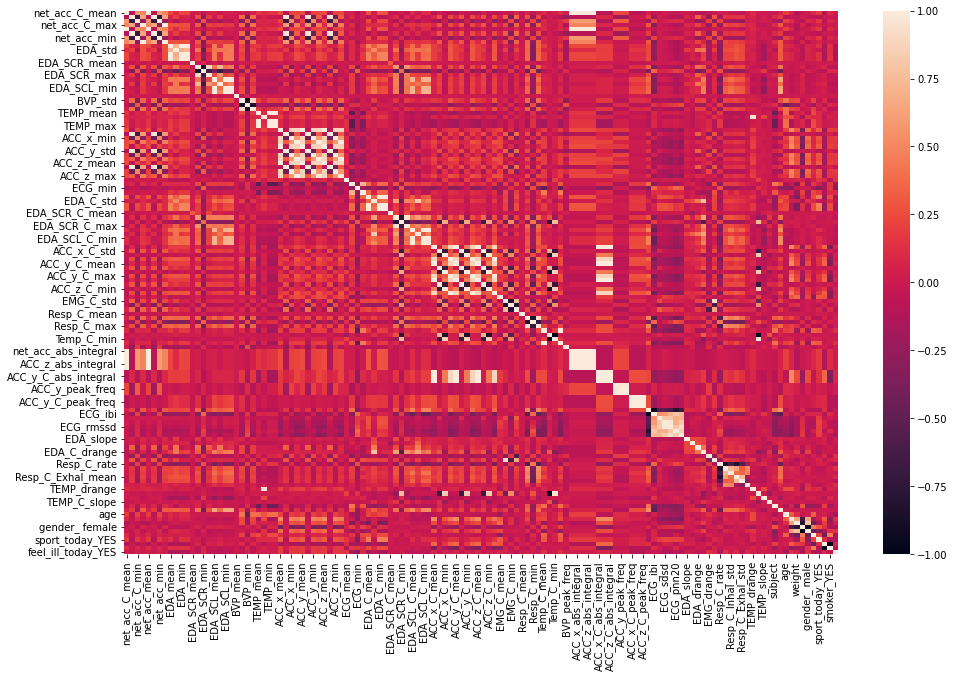

In [147]:
corr = df.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr);

In [148]:
df = df.loc[:, df.columns != 'Resp_C_rate']

In [149]:
features = df.loc[:, df.columns != 'label'].columns

In [150]:
for ft_idx in range(len(features)):
    print(features[ft_idx], ft_idx)

net_acc_C_mean 0
net_acc_C_std 1
net_acc_C_min 2
net_acc_C_max 3
net_acc_mean 4
net_acc_std 5
net_acc_min 6
net_acc_max 7
EDA_mean 8
EDA_std 9
EDA_min 10
EDA_max 11
EDA_SCR_mean 12
EDA_SCR_std 13
EDA_SCR_min 14
EDA_SCR_max 15
EDA_SCL_mean 16
EDA_SCL_std 17
EDA_SCL_min 18
EDA_SCL_max 19
BVP_mean 20
BVP_std 21
BVP_min 22
BVP_max 23
TEMP_mean 24
TEMP_std 25
TEMP_min 26
TEMP_max 27
ACC_x_mean 28
ACC_x_std 29
ACC_x_min 30
ACC_x_max 31
ACC_y_mean 32
ACC_y_std 33
ACC_y_min 34
ACC_y_max 35
ACC_z_mean 36
ACC_z_std 37
ACC_z_min 38
ACC_z_max 39
ECG_mean 40
ECG_std 41
ECG_min 42
ECG_max 43
EDA_C_mean 44
EDA_C_std 45
EDA_C_min 46
EDA_C_max 47
EDA_SCR_C_mean 48
EDA_SCR_C_std 49
EDA_SCR_C_min 50
EDA_SCR_C_max 51
EDA_SCL_C_mean 52
EDA_SCL_C_std 53
EDA_SCL_C_min 54
EDA_SCL_C_max 55
ACC_x_C_mean 56
ACC_x_C_std 57
ACC_x_C_min 58
ACC_x_C_max 59
ACC_y_C_mean 60
ACC_y_C_std 61
ACC_y_C_min 62
ACC_y_C_max 63
ACC_z_C_mean 64
ACC_z_C_std 65
ACC_z_C_min 66
ACC_z_C_max 67
EMG_C_mean 68
EMG_C_std 69
EMG_C_min 70
E

In [151]:
X = df.drop('label', axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

# Modeling

## Cross Validation

### K-Fold Cross Validation

### Leave-One-Out Cross Validation

## Linear Discriminant Analysis

In [152]:
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  


lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

In [153]:
cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))  
lda_baseline_acc = accuracy_score(y_test, y_pred)

[[ 34   8   1]
 [  3 122   1]
 [  2   0  65]]
Accuracy: 0.9364406779661016


### Feature Importance (Top 20)

## Random Forest Classifier

In [154]:
classifier = RandomForestClassifier(max_depth=4, random_state=0)
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test)  

In [155]:
cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))  
rf_baseline_acc = accuracy_score(y_test, y_pred)

[[ 35   7   1]
 [  3 121   2]
 [  0   0  67]]
Accuracy: 0.9449152542372882


### Feature Importance (Top 20)

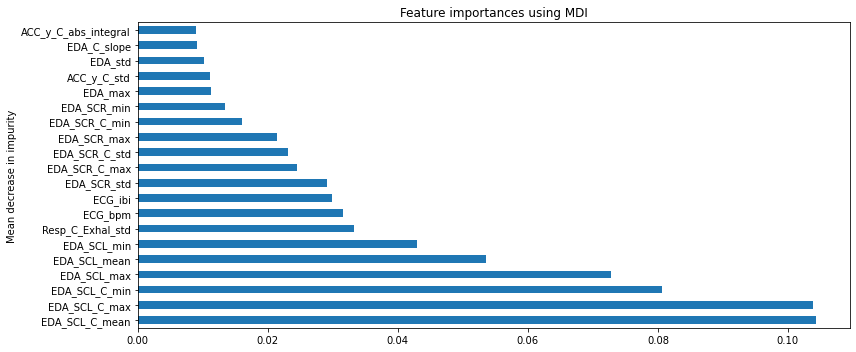

In [156]:
importances = classifier.feature_importances_
forest_importances = pd.Series(importances, index=features).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
forest_importances[:20].plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Support Vector Machine

### Linear SVM

In [157]:
# Create a SVC classifier using a linear kernel
clf = SVC(kernel='linear', C=1, random_state=0)
# Train the classifier
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_out = clf.predict(X_test)
lm_svc=(classification_report(y_test, y_out, digits=4))
print(lm_svc)
svm_baseline_acc = accuracy_score(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.9744    0.8837    0.9268        43
           1     0.9690    0.9921    0.9804       126
           2     0.9853    1.0000    0.9926        67

    accuracy                         0.9746       236
   macro avg     0.9762    0.9586    0.9666       236
weighted avg     0.9746    0.9746    0.9741       236



### Feature Importance (Top 20)

<AxesSubplot:>

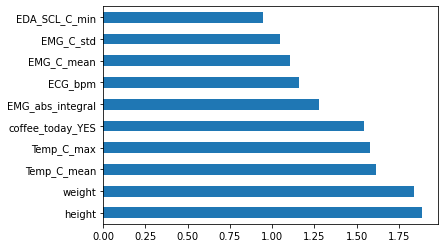

In [158]:
pd.Series(abs(clf.coef_[0]), index=features).nlargest(10).plot(kind='barh')

### Linear SVM (lambda 2)

In [170]:
# Create a SVC classifier using a linear kernel
clf = SVC(kernel='linear', C=0.9, random_state=0)
# Train the classifier
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_out = clf.predict(X_test)
lm_svc=(classification_report(y_test, y_out, digits=4))
print(lm_svc)
svm_baseline_acc = accuracy_score(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.9750    0.9070    0.9398        43
           1     0.9766    0.9921    0.9843       126
           2     0.9853    1.0000    0.9926        67

    accuracy                         0.9788       236
   macro avg     0.9790    0.9663    0.9722       236
weighted avg     0.9788    0.9788    0.9785       236



<AxesSubplot:>

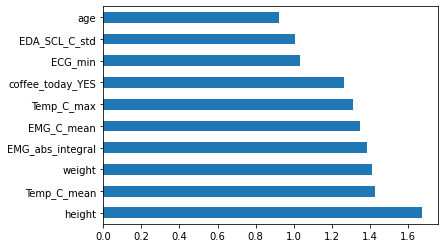

In [23]:
pd.Series(abs(clf.coef_[0]), index=features).nlargest(10).plot(kind='barh')

### Feature Importance (Top 20)

# Adding Noise

## Signal to Noise Ratio

For a non-constant signal $S$ and noise $N$, the signal to noise ratio is defined as the following:
$$ SNR = \frac{\mathbb{E}[S^2]}{\mathbb{E}[N^2]} $$

The expected value $\mathbb{E}[X]$ of any continuous random variable $X$ is $\int_{-\infty}^{\infty} x p(x) dx $, where $p(x)$ is its associated probability density function.

For homoskedastic noise, we can use closed form expressions to compute $E[N^2]$.

- For Gaussian distributed noise $N$ ~ $n(\mu, \sigma^2)$, notice that $\text{V}[N] = \mathbb{E}[N^2] - (\mathbb{E}[N])^2,$ so $\mathbb{E}[N^2] = \text{V}[N] + (\mathbb{E}[N])^2 = \sigma^2 + \mu$. In our case $\mu = 0$, so $\mathbb{E}[N^2] = \sigma^2$.

- For uniformly distributed noise $N$ ~ $u(\alpha, \beta)$, by the same logic as above $\mathbb{E}[N^2] = \left(\frac{\alpha - \beta}{2}\right)^2$.

- For frequency-domain noise $N$ of the form $A\sin(2\pi x \frac{1}{f}) + y, \mathbb{E}[N^2] \approx y^2 + \frac{A^2}{2}$. Note the $\approx$ since we cannot guarantee that the signal will end precisely on the end of the sin wave.

For heteroskedastic noise, because there is no closed form expression, we simply take `N.mean()` where $N$ is our noise

In [185]:
def signal_to_noise_ratio(signal, noise_type, noise_dist, noise=None, sigma=None, alpha=None, beta=None, 
                          vertical_shift=None, amplitude=None):
    """
    Function: Computes the signal to noise ratio for a given signal and its corresponding noise.
    
    :param:
        signal (array or ndarray): The signal we are evaluating
        noise_type (string): 'Heteroskedastic' or 'Homoskedastic'
        noise_dist (string): 'Uniform', 'Gaussian', or 'Frequency' for now
        noise (array or ndarray): Only passed in if we have heteroskedastic noise
        sigma (float): Sigma parameter of the gaussian
        alpha (float): Alpha parameter of the uniform
        beta (float): Beta parameter of the uniform
        vertical_shift (float): Vertical shift parameter of the frequency
        amplitude (float): Amplitude parameter of the frequency
        
    :return
        signal_to_noise_ratio (float): Signal to noise ratio... E[S^2]/E[N^2]
    """
    
    # Calculate E[S^2]
    e_s2 = (signal**2).mean()
    e_n2 = None
    
    if noise_type == 'Homoskedastic':
        # Calculate E[N^2] for the pertinent case
        if noise_dist == 'Uniform':
            e_n2 = (0.5*(alpha - beta))**2
        elif noise_dist == 'Gaussian':
            e_n2 = sigma**2
        elif noise_dist == 'Frequency':
            e_n2 = vertical_shift**2 + (amplitude**2)/2
    elif noise_type == 'Heteroskedastic':
        e_n2 = (noise**2).mean()
    
    # Return the signal to noise ratio
    return e_s2/e_n2

## Denoising Using Principal Component Analysis

Let $X$ represent our set of physiological signals and $\textbf{x}_i$ denote the *i*-th column of $X$. In our case, $\textbf{x}_i$ is one of the ECG, BVP, EDA, ACC, etc. The post-noise signal we observe $\textbf{x}_i = \widetilde{\textbf{x}}_i + \xi_i$ is composed of the original raw signal and Gaussian distributed noise with $\mathbb{E}[\xi] = 0$ and $V[\xi] = E[N^2] = \sigma^2 = \frac{\mathbb{E}[S^2]}{SNR}$. Literature has indicated that a principal component analysis of $\textbf{x}_i$ can produce an estimate of $\widetilde{\textbf{x}}_i$ that is closer than the noisy measurements are (citation needed).

## Calculate Distribution Parameters from SNR

Given a signal $S$, we can specify a signal to noise ratio $SNR = \frac{\mathbb{E}[S^2]}{\mathbb{E}[N^2]}$ and use this to calculate $\mathbb{E}[N^2]$ because $SNR$ and $\mathbb{E}[S^2]$ are known. So $\mathbb{E}[N^2] = \frac{\mathbb{E}[S^2]}{SNR}$.

Then, for any homoskedastic noise following a well-defined probability density function (PDF), we can solve for the parameters of the PDF using the known value $\mathbb{E}[N^2]$.

- For Gaussian distributed noise $N$ ~ $n(\mu, \sigma^2)$, notice that $\text{V}[N] = \mathbb{E}[N^2] - (\mathbb{E}[N])^2,$ so $\mathbb{E}[N^2] = \text{V}[N] + (\mathbb{E}[N])^2 = \sigma^2 + \mu$. In our case $\mu = 0$, so $\mathbb{E}[N^2] = \sigma^2$. Thus, $\sigma^2 = \frac{\mathbb{E}[S^2]}{SNR}$.

In [210]:
def calculate_param(signal, noise_type, signal_to_noise_ratio):
    """
    Function: Calculates the parameters of a continuous probability density function given
    our desired signal to noise ratio and signal.
    
    :param:
        signal (array or ndarray): Our signal
        noise_type (string): Probability distribution of our noise (i.e., Gaussian)
        signal_to_noise_ratio (float): Desired signal to noise ratio
    
    :return
    (for now, just)
        sigma (float): sigma of the gaussian
    """
    
    return (signal**2).mean()/signal_to_noise_ratio

## Gaussian Noise

The Gaussian probability density function is of the following form:
\begin{equation}\label{eq:}
f(x) = \frac{1}{\sigma \sqrt{2 \pi}}exp\left(-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2\right)
\end{equation}

### Estimating $\mu$ and $\sigma$ of the Gaussian

#### Greatest $n$-Differential with Homoskedasticity Approach

For a signal $S$, the greatest $n$-differential with homoskedasticity approach constructs a Gaussian distribution such that $\mu$ = 0 and $\sigma = \alpha \cdot max(|S_i - S_{i+n}|)$, where $max(|S_i - S_{i+n}|)$ denotes the maximum absolute difference of the signal between index $i$ and $i+n$ in the entire signal, and $\alpha$ is a parameter that multiplicatively scales the intensity of the added noise. We can choose to set $n$ to any value, although we have empirically found $n = 5$ to be the best. We set $\mu$ to $0$ so we don't vertically shift the original signal after adding noise. 

In conclusion, we randomly sample from the following probability density function:
$$
f(x) = \frac{1}{\alpha \cdot max(|S_i - S_{i+n}|) \sqrt{2 \pi}}exp\left(-\frac{1}{2}\left(\frac{x}{\alpha \cdot max(|S_i - S_{i+n}|)}\right)^2\right)
$$

This noise exhbits homoskedasticity because it does not vary with time.

In [188]:
def gaussian_homoskedastic(signal_name, signal, signal_to_noise_ratio=None):
    """
    Constructs a homoskedastic gaussian probability density function, samples noise from it,
    then adds noise to the signal
    
    :param:
        signal_name (string): The name of the signal (i.e., ECG)
        signal (array or ndarray): The signal we wish to add noise to
        signal_to_noise_ratio (float): [default: None] If specified, our desired SNR.
        
    :return
        noisy_signal: The signal after we have added noise to it
    """
    
    x_new = None

    if signal_name == 'ACC':
        alpha = 0.5
        mu = 0
        # Noise X Axis
        x_axis = signal[:,0]
        sigma = calculate_param(x_axis, 'Gaussian', signal_to_noise_ratio)
        s = np.random.normal(mu, sigma, 1000)
        x_axis_new = np.copy(x_axis)
        for i in range(len(x_axis_new)):
            x_axis_new[i] += float(np.random.normal(mu, sigma, 1))
        # Noise Y Axis
        y_axis = signal[:,1]
        sigma = calculate_param(y_axis, 'Gaussian', signal_to_noise_ratio)
        s = np.random.normal(mu, sigma, 1000)
        y_axis_new = np.copy(y_axis)
        for i in range(len(y_axis_new)):
            y_axis_new[i] += float(np.random.normal(mu, sigma, 1))
        # Noise Z Axis
        z_axis = signal[:,2]
        sigma = calculate_param(z_axis, 'Gaussian', signal_to_noise_ratio)
        s = np.random.normal(mu, sigma, 1000)
        z_axis_new = np.copy(z_axis)
        for i in range(len(z_axis_new)):
            z_axis_new[i] += float(np.random.normal(mu, sigma, 1))

        # Put together noisy signal
        x_new = np.zeros((len(signal), 3))
        x_new[:,0] = x_axis_new
        x_new[:,1] = y_axis_new
        x_new[:,2] = z_axis_new

        return (x_new, sigma)
    else: 
        # Store original shape
        original_shape = signal.shape

        # Caveat: some signals like ACC have three axes
        # Flatten signal to be 1d
        x = np.ravel(signal)

        # Calculate mean and Standard deviation
        alpha = 0.5
        mu = 0
        sigma = calculate_param(x, 'Gaussian', signal_to_noise_ratio)

        # test that this works
        x_new = x + np.random.normal(mu, sigma, (len(x),))

#         for i in range(len(x_new)):
#             x_new[i] += float(np.random.normal(mu, sigma, 1))

        return (np.array(x_new).reshape(original_shape), sigma)

#### Greatest $n$-Differential Approach with Heteroskedasticity

For a signal $S$, the greatest $n$-differential with heteroskedasticity approach constructs a Gaussian probability density function such that $\mu$ = 0 and $\sigma = \alpha \cdot max(|S_{t-100\thinspace\leq\thinspace i \thinspace\leq\thinspace t} - S_{t-100\thinspace\leq\thinspace i+n \thinspace\leq\thinspace t}|)$, where $max(|S_{t-100\thinspace\leq\thinspace i \thinspace\leq\thinspace t} - S_{t-100\thinspace\leq\thinspace i+n \thinspace\leq\thinspace t}|)$ denotes the maximum absolute difference of the signal between any index $i$ and $i+n$ in the last $100$ samples from index $t$, and $\alpha$ is a parameter that multiplicatively scales the intensity of the added noise. We can choose to set $n$ to any value, although we have empirically found $n = 5$ to be the best. We set $\mu$ to $0$ so we don't vertically shift the original signal after adding noise. 

At each fixed time value $t \in [S_{start}, S_{end}]$, we randomly sample from the following probability density function:
$$
\epsilon_t = f(x, t) = \frac{1}{\alpha \cdot max(|S_{t-100\thinspace\leq\thinspace i \thinspace\leq\thinspace t} - S_{t-100\thinspace\leq\thinspace i+n \thinspace\leq\thinspace t}|) \sqrt{2 \pi}}exp\left(-\frac{1}{2}\left(\frac{x}{\alpha \cdot max(|S_{t-100\thinspace\leq\thinspace i \thinspace\leq\thinspace t} - S_{t-100\thinspace\leq\thinspace i+n \thinspace\leq\thinspace t}|)}\right)^2\right)
$$

We add each $\epsilon_t$ to its respective value of $S_t$ to add noise to the signal. 

In [189]:
def gaussian_heteroskedastic(signal):
    """
    Constructs a heteroskedastic gaussian probability density function, samples noise from it,
    then adds noise to the signal
    
    :param:
        signal (array or ndarray): The signal we wish to add noise to
        
    :return
        noisy_signal: The signal after we have added noise to it
    """
    
    # Store original shape
    original_shape = signal.shape
    
    # Caveat: some signals like ACC have three axes
    # Flatten signal to be 1d
    x = np.ravel(signal)
    
    # Calculate mean and Standard deviation
    alpha = 0.5
    mu = 0
    sigma = None
    
    # Add heteroskedastic noise
    x_new = np.copy(x)
    noise = np.array([])
    window_len = 100
    for i in range(100, len(x)):
        x_rolling = x[i-100:i]
        sigma = alpha*abs(x_rolling - np.roll(x_rolling, 5)).max()
        noise_i = float(np.random.normal(mu, sigma, 1))
        np.append(noise, noise_i)
        x_new[i] += noise_i
    for i in range(len(x)-100, len(x)):
        x_new[len(x)-i] += float(np.random.normal(mu, sigma, 1))  

    return (np.array(x_new).reshape(original_shape), signal_to_noise_ratio(signal=x, noise=noise, noise_type='Heteroskedastic', 
                                        noise_dist='Gaussian'))

## Frequency Domain Noise

A sinusoidal wave is of the form:

\begin{equation}\label{eq:1}
f(x) = Asin(2 \pi T*x) + y
\end{equation}

where $A$ is the amplitude of the wave, $T = \frac{1}{f}$ is the period, and $y$ is the vertical shift. Note that we have omitted the phase shift parameter since we will overlay the noise to the data at pre-determined locations.

In [190]:
# Constructs a sinusoidal wave
def sinusoidal_wave(amplitude, frequency, vertical_shift, x):
    return amplitude * np.sin(2*np.pi*(1/frequency)*x) + vertical_shift

Each physiological signal has a different sampling frequency.

In [191]:
fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 700, 'Resp': 700, 'ECG': 700}

In [192]:
def frequency(signal, hz):
    """
    Constructs a heteroskedastic gaussian probability density function, samples noise from it,
    then adds noise to the signal
    
    :param:
        signal (array or ndarray): The signal we wish to add noise to
        hz (float): The hertz (frequency) at which we wish to add noise)
        
    :return
        noisy_signal: The signal after we have added noise to it
    """
    
    # Store original shape
    original_shape = signal.shape
    
    # Caveat: some signals like ACC have three axes
    # Flatten signal to be 1d
    x = np.ravel(signal)
    
    # Caveat: each signal has a different base sampling frequency
    # Add frequency noise
    sinusoidal_wave(amplitude, 1/hz, vertical_shift, x)
    x_new = np.copy(x)

    return np.array(x_new).reshape(original_shape)

### Estimating $A$, $T$ and $y$ of the Sinusoidal

## Exporting Noisy Files

### Function to Write File

In [193]:
def write_file(path, file_name, data):
    """
    Function: Writes filename to its specified path and then dumps data in .pkl format to that file.
    
    :param:
        path (string): Where you want to write (create) the file
        file_name (string): What you want to name the file you're creating
        data (array or ndarray or pd.DataFrame): What you want inside the file you're creating
    
    """
    
    filename = file_name + '.pkl'
    with open(os.path.join(path, filename), 'wb') as dest:
        pickle.dump(data, dest)

Root Directory (you will likely need to change, unless you are Sam)

In [244]:
rootdir = '/Users/samuelschapiro/Desktop/Research/HCDL/data/WESAD'

### Function to Add Noise

In [245]:
snrs = [0.01, 0.05, 0.1, 0.2, 0.5]

In [444]:
snrs = [0.001, 0.15, 0.3, 0.4, 0.6]

In [494]:
snrs = [0.0001, 0.00001]

In [495]:
def add_noise(rootdir, snrs, body_parts=['wrist', 'chest'],
              signals={'wrist': ['ACC', 'BVP', 'EDA', 'TEMP'],'chest': ['ECG', 'Temp', 'EMG', 'Resp', 'ACC']}):
    """
    Function: Adds noise to the WESAD data, stored in the specified root directory
    
    :param:
        rootdir (string): The root directory from which to read the WESAD data.
        body_parts (list): [Default: '[wrist', 'chest']] Body parts from which to read the WESAD data
        signals (dict): [Default: see above] The physiological signals each body part has
    :return
        None
    """
    snr=snrs
    patients = []
    patients_with_noise1 = []
    patients_with_noise2 = []
    patients_with_noise3 = []
    patients_with_noise4 = []
    patients_with_noise5 = []
    patient_idx = 0
    # Iterate through each patient's folder and construct a df with all patient data
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            # If this is a .pkl file then it's the synchronized features/labels
            # and we want to serialize the file
            if '.pkl' in file and 'gauss' not in file: 
                # For each signal to noise ratio we want to test
                # Serialize
                patients.append(pd.read_pickle(subdir + '/' + file))
                patients_with_noise1.append(pd.read_pickle(subdir + '/' + file))
                patients_with_noise2.append(pd.read_pickle(subdir + '/' + file))
                patients_with_noise3.append(pd.read_pickle(subdir + '/' + file))
                patients_with_noise4.append(pd.read_pickle(subdir + '/' + file))                
                patients_with_noise5.append(pd.read_pickle(subdir + '/' + file))
                for body_part in body_parts:
                    # Add noise
                    for sgl in signals[body_part]:
                        # Get signal
                        signal = patients[patient_idx]['signal'][body_part][sgl]

                        # Get gaussian homoskedastic noise1
                        x_gaussian_homoskedastic1, sigma1 = gaussian_homoskedastic(sgl, signal, snr[0])
                        patients_with_noise1[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic1

                        # Get gaussian homoskedastic noise2
                        x_gaussian_homoskedastic2, sigma2 = gaussian_homoskedastic(sgl, signal, snr[1])
                        patients_with_noise2[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic2
                        
#                         # Get gaussian homoskedastic noise3
#                         x_gaussian_homoskedastic3, sigma3 = gaussian_homoskedastic(sgl, signal, snr[2])
#                         patients_with_noise3[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic3
                        
#                         # Get gaussian homoskedastic noise2
#                         x_gaussian_homoskedastic4, sigma4 = gaussian_homoskedastic(sgl, signal, snr[3])
#                         patients_with_noise4[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic4
                        
#                         # Get gaussian homoskedastic noise3
#                         x_gaussian_homoskedastic5, sigma5 = gaussian_homoskedastic(sgl, signal, snr[4])
#                         patients_with_noise5[patient_idx]['signal'][body_part][sgl] = x_gaussian_homoskedastic5
                        
                # Export each noise type
                write_file(subdir, file.split('.')[0]+'_gauss_homo_snr_'+str(snr[0]), 
                           patients_with_noise1[patient_idx])
                
                # Export each noise type
                write_file(subdir, file.split('.')[0]+'_gauss_homo_snr_'+str(snr[1]), 
                           patients_with_noise2[patient_idx])
                
#                 # Export each noise type
#                 write_file(subdir, file.split('.')[0]+'_gauss_homo_snr_'+str(snr[2]), 
#                            patients_with_noise3[patient_idx])
                
#                 # Export each noise type
#                 write_file(subdir, file.split('.')[0]+'_gauss_homo_snr_'+str(snr[3]), 
#                            patients_with_noise4[patient_idx])
                
#                 # Export each noise type
#                 write_file(subdir, file.split('.')[0]+'_gauss_homo_snr_'+str(snr[4]), 
#                            patients_with_noise5[patient_idx])
                
                # Increment patient index
                patient_idx += 1

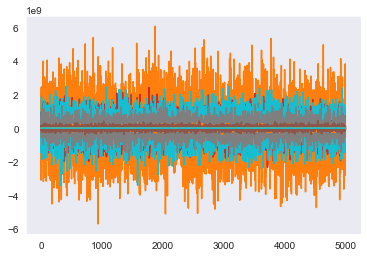

In [496]:
add_noise(rootdir, snrs)

# Feature Extraction (pt. 2)

Do feature extraction again, this time with the noisy data

In [248]:
patients_new_noise1 = []
patients_new_noise2 = []
patients_new_noise3 = []
patients_new_noise4 = []
patients_new_noise5 = []
# Iterate through each patient's folder and construct a
# df with all patient data
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        # If this is a .pkl file then it's the synchronized features/labels
        # and we want to serialize the file
        if '.pkl' in file and 'gauss' in file and 'snr_0.01' in file:
            patients_new_noise1.append(pd.read_pickle(subdir + '/' + file))
        elif '.pkl' in file and 'gauss' in file and 'snr_0.05' in file:
            patients_new_noise2.append(pd.read_pickle(subdir + '/' + file))
        elif '.pkl' in file and 'gauss' in file and 'snr_0.1' in file:
            patients_new_noise3.append(pd.read_pickle(subdir + '/' + file))
        elif '.pkl' in file and 'gauss' in file and 'snr_0.2' in file:
            patients_new_noise4.append(pd.read_pickle(subdir + '/' + file))
        elif '.pkl' in file and 'gauss' in file and 'snr_0.5' in file:
            patients_new_noise5.append(pd.read_pickle(subdir + '/' + file))

Text(0.5, 1.0, 'SNR: 0.5')

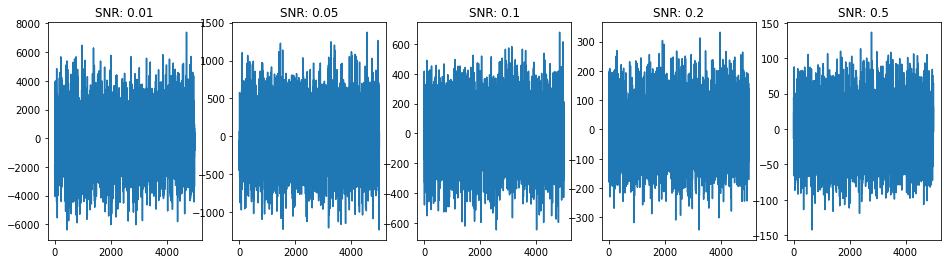

In [299]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
axs[0].plot(np.ravel(patients_new_noise1[0]['signal']['chest']['Resp'])[4015000:4020000])
axs[0].set_title('SNR: 0.01')
axs[1].plot(np.ravel(patients_new_noise2[0]['signal']['chest']['Resp'])[4015000:4020000])
axs[1].set_title('SNR: 0.05')
axs[2].plot(np.ravel(patients_new_noise3[0]['signal']['chest']['Resp'])[4015000:4020000])
axs[2].set_title('SNR: 0.1')
axs[3].plot(np.ravel(patients_new_noise4[0]['signal']['chest']['Resp'])[4015000:4020000])
axs[3].set_title('SNR: 0.2')
axs[4].plot(np.ravel(patients_new_noise5[0]['signal']['chest']['Resp'])[4015000:4020000])
axs[4].set_title('SNR: 0.5')

# Data Preparation (pt. 2)

Prepare the data again, this time with the noisy data

In [ ]:
snrs = [0.001, 0.15, 0.3, 0.4, 0.6]

In [484]:
# Class to store the data for each subject
class SubjectDataWithNoise:

    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '_gauss_homo_snr_0.6.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']

    def get_wrist_data(self):
        data = self.data['signal']['wrist']
        data.update({'ACC_C': self.data['signal']['chest']['ACC'],
                     'ECG_C': self.data['signal']['chest']['ECG'],
                     'EDA_C': self.data['signal']['chest']['EDA'],
                     'EMG_C': self.data['signal']['chest']['EMG'],
                     'Resp_C': self.data['signal']['chest']['Resp'],
                     'Temp_C': self.data['signal']['chest']['Temp']
                     })
        return data

    def get_chest_data(self):
        return self.data['signal']['chest']

    def extract_features(self):  # only wrist
        results = \
            {
                key: get_statistics(self.get_wrist_data()[key].flatten(), self.labels, key)
                for key in self.wrist_keys
            }
        return results

In [485]:
def make_patient_data_with_noise(subject_id):
    global savePath
    global WINDOW_IN_SECONDS

    # Make subject data object for Sx
    subject = SubjectDataWithNoise(main_path='data/WESAD', subject_number=subject_id)

    # Empatica E4 data - now with resp
    e4_data_dict = subject.get_wrist_data()
    
    # Chest data
    ch_data_dict = subject.get_chest_data()

    # norm type
    norm_type = None

    # The 3 classes we are classifying
    grouped, baseline, stress, amusement = compute_features(e4_data_dict, ch_data_dict, subject.labels, norm_type)

    # print(f'Available windows for {subject.name}:')
    n_baseline_wdws = int(len(baseline) / (fs_dict['label'] * WINDOW_IN_SECONDS))
    n_stress_wdws = int(len(stress) / (fs_dict['label'] * WINDOW_IN_SECONDS))
    n_amusement_wdws = int(len(amusement) / (fs_dict['label'] * WINDOW_IN_SECONDS))
    # print(f'Baseline: {n_baseline_wdws}\nStress: {n_stress_wdws}\nAmusement: {n_amusement_wdws}\n')

    #
    baseline_samples = get_samples(baseline, n_baseline_wdws, 1)
    for col in baseline_samples.columns:
        print(col)
    # Downsampling
    # baseline_samples = baseline_samples[::2]
    stress_samples = get_samples(stress, n_stress_wdws, 2)
    amusement_samples = get_samples(amusement, n_amusement_wdws, 0)

    all_samples = pd.concat([baseline_samples, stress_samples, amusement_samples])
    all_samples = pd.concat([all_samples.drop('label', axis=1), pd.get_dummies(all_samples['label'])], axis=1)
    # Save file as csv
    all_samples.to_csv(f'{savePath}{subject_feature_path}/S{subject_id}_feats_with_noise_0.6.csv')

    subject = None

In [486]:
def combine_files_with_noise(subjects):
    df_list = []
    for s in subjects:
        df = pd.read_csv(f'{savePath}{subject_feature_path}/S{s}_feats_with_noise_0.6.csv', index_col=0)
        df['subject'] = s
        df_list.append(df)

    df = pd.concat(df_list)

    df['label'] = (df['0'].astype(str) + df['1'].astype(str) + df['2'].astype(str)).apply(lambda x: x.index('1'))
    df.drop(['0', '1', '2'], axis=1, inplace=True)

    df.reset_index(drop=True, inplace=True)

    print('here')
    df.to_csv(f'{savePath}/may14_feats4_with_noise.csv')

    counts = df['label'].value_counts()
    print('Number of samples per class:')
    for label, number in zip(counts.index, counts.values):
        print(f'{int_to_label[label]}: {number}')


if __name__ == '__main__':

    subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

    for patient in subject_ids:
        print(f'Processing data for S{patient}...')
        make_patient_data_with_noise(patient)

    combine_files_with_noise(subject_ids)
    print('Processing complete.')

Processing data for S2...
     pcost       dcost       gap    pres   dres
 0: -7.2291e+03 -6.7393e+03  6e+04  2e+02  4e-01
 1: -7.6271e+03 -1.8053e+04  1e+04  5e+01  8e-02
 2: -8.3577e+03 -1.4391e+04  6e+03  2e+01  3e-02
 3: -9.0407e+03 -1.3307e+04  4e+03  1e+01  2e-02
 4: -9.6895e+03 -1.2943e+04  3e+03  7e+00  9e-03
 5: -1.0319e+04 -1.2811e+04  3e+03  4e+00  5e-03
 6: -1.0848e+04 -1.2872e+04  2e+03  2e+00  3e-03
 7: -1.1284e+04 -1.2730e+04  1e+03  1e+00  2e-03
 8: -1.1531e+04 -1.2571e+04  1e+03  6e-01  9e-04
 9: -1.1640e+04 -1.2152e+04  5e+02  2e-01  3e-04
10: -1.1676e+04 -1.1842e+04  2e+02  5e-02  7e-05
11: -1.1698e+04 -1.1754e+04  6e+01  1e-02  2e-05
12: -1.1707e+04 -1.1719e+04  1e+01  1e-04  2e-07
13: -1.1710e+04 -1.1713e+04  3e+00  9e-06  1e-08
14: -1.1711e+04 -1.1712e+04  6e-01  1e-06  2e-09
15: -1.1711e+04 -1.1711e+04  1e-01  2e-07  3e-10
16: -1.1711e+04 -1.1711e+04  2e-02  3e-08  4e-11
17: -1.1711e+04 -1.1711e+04  4e-03  3e-09  4e-12
18: -1.1711e+04 -1.1711e+04  6e-04  3e-10  7

net_acc_C_mean
net_acc_C_std
net_acc_C_min
net_acc_C_max
net_acc_mean
net_acc_std
net_acc_min
net_acc_max
EDA_mean
EDA_std
EDA_min
EDA_max
EDA_SCR_mean
EDA_SCR_std
EDA_SCR_min
EDA_SCR_max
EDA_SCL_mean
EDA_SCL_std
EDA_SCL_min
EDA_SCL_max
EDA_phasic_mean
EDA_phasic_std
EDA_phasic_min
EDA_phasic_max
EDA_smna_mean
EDA_smna_std
EDA_smna_min
EDA_smna_max
EDA_tonic_mean
EDA_tonic_std
EDA_tonic_min
EDA_tonic_max
BVP_mean
BVP_std
BVP_min
BVP_max
TEMP_mean
TEMP_std
TEMP_min
TEMP_max
ACC_x_mean
ACC_x_std
ACC_x_min
ACC_x_max
ACC_y_mean
ACC_y_std
ACC_y_min
ACC_y_max
ACC_z_mean
ACC_z_std
ACC_z_min
ACC_z_max
ECG_mean
ECG_std
ECG_min
ECG_max
EDA_C_mean
EDA_C_std
EDA_C_min
EDA_C_max
EDA_SCR_C_mean
EDA_SCR_C_std
EDA_SCR_C_min
EDA_SCR_C_max
EDA_SCL_C_mean
EDA_SCL_C_std
EDA_SCL_C_min
EDA_SCL_C_max
ACC_x_C_mean
ACC_x_C_std
ACC_x_C_min
ACC_x_C_max
ACC_y_C_mean
ACC_y_C_std
ACC_y_C_min
ACC_y_C_max
ACC_z_C_mean
ACC_z_C_std
ACC_z_C_min
ACC_z_C_max
EMG_C_mean
EMG_C_std
EMG_C_min
EMG_C_max
Resp_C_mean
Resp_C_std


Processing data for S7...
     pcost       dcost       gap    pres   dres
 0: -1.4450e+03 -6.1269e+02  6e+04  3e+02  2e+00
 1: -2.1373e+03 -1.5282e+04  2e+04  7e+01  4e-01
 2: -3.2584e+03 -1.2944e+04  1e+04  3e+01  2e-01
 3: -4.3091e+03 -1.0795e+04  7e+03  2e+01  1e-01
 4: -5.5013e+03 -1.0396e+04  5e+03  1e+01  6e-02
 5: -6.6334e+03 -1.0399e+04  4e+03  6e+00  4e-02
 6: -7.6524e+03 -1.0918e+04  3e+03  4e+00  2e-02
 7: -8.5048e+03 -1.1272e+04  3e+03  2e+00  1e-02
 8: -9.1382e+03 -1.1339e+04  2e+03  1e+00  9e-03
 9: -9.5622e+03 -1.0977e+04  1e+03  7e-01  4e-03
10: -9.7335e+03 -1.0672e+04  9e+02  4e-01  2e-03
11: -9.8005e+03 -1.0199e+04  4e+02  1e-01  7e-04
12: -9.8321e+03 -9.9001e+03  7e+01  1e-02  9e-05
13: -9.8416e+03 -9.8593e+03  2e+01  3e-03  2e-05
14: -9.8445e+03 -9.8487e+03  4e+00  2e-04  1e-06
15: -9.8455e+03 -9.8463e+03  9e-01  3e-05  2e-07
16: -9.8457e+03 -9.8459e+03  2e-01  5e-06  3e-08
17: -9.8457e+03 -9.8457e+03  4e-02  6e-07  4e-09
18: -9.8457e+03 -9.8457e+03  9e-03  1e-07  7

net_acc_C_mean
net_acc_C_std
net_acc_C_min
net_acc_C_max
net_acc_mean
net_acc_std
net_acc_min
net_acc_max
EDA_mean
EDA_std
EDA_min
EDA_max
EDA_SCR_mean
EDA_SCR_std
EDA_SCR_min
EDA_SCR_max
EDA_SCL_mean
EDA_SCL_std
EDA_SCL_min
EDA_SCL_max
EDA_phasic_mean
EDA_phasic_std
EDA_phasic_min
EDA_phasic_max
EDA_smna_mean
EDA_smna_std
EDA_smna_min
EDA_smna_max
EDA_tonic_mean
EDA_tonic_std
EDA_tonic_min
EDA_tonic_max
BVP_mean
BVP_std
BVP_min
BVP_max
TEMP_mean
TEMP_std
TEMP_min
TEMP_max
ACC_x_mean
ACC_x_std
ACC_x_min
ACC_x_max
ACC_y_mean
ACC_y_std
ACC_y_min
ACC_y_max
ACC_z_mean
ACC_z_std
ACC_z_min
ACC_z_max
ECG_mean
ECG_std
ECG_min
ECG_max
EDA_C_mean
EDA_C_std
EDA_C_min
EDA_C_max
EDA_SCR_C_mean
EDA_SCR_C_std
EDA_SCR_C_min
EDA_SCR_C_max
EDA_SCL_C_mean
EDA_SCL_C_std
EDA_SCL_C_min
EDA_SCL_C_max
ACC_x_C_mean
ACC_x_C_std
ACC_x_C_min
ACC_x_C_max
ACC_y_C_mean
ACC_y_C_std
ACC_y_C_min
ACC_y_C_max
ACC_z_C_mean
ACC_z_C_std
ACC_z_C_min
ACC_z_C_max
EMG_C_mean
EMG_C_std
EMG_C_min
EMG_C_max
Resp_C_mean
Resp_C_std


Processing data for S13...
     pcost       dcost       gap    pres   dres
 0: -1.6120e+03 -7.4452e+02  7e+04  3e+02  1e+00
 1: -2.3611e+03 -1.4760e+04  2e+04  7e+01  4e-01
 2: -3.6527e+03 -1.1842e+04  9e+03  3e+01  2e-01
 3: -4.9944e+03 -1.0815e+04  6e+03  1e+01  8e-02
 4: -6.1421e+03 -1.1027e+04  5e+03  1e+01  5e-02
 5: -7.3167e+03 -1.1008e+04  4e+03  6e+00  3e-02
 6: -8.2884e+03 -1.1445e+04  3e+03  4e+00  2e-02
 7: -9.1566e+03 -1.1709e+04  3e+03  2e+00  1e-02
 8: -9.7676e+03 -1.1894e+04  2e+03  1e+00  8e-03
 9: -1.0108e+04 -1.1759e+04  2e+03  8e-01  5e-03
10: -1.0294e+04 -1.1232e+04  9e+02  4e-01  2e-03
11: -1.0363e+04 -1.0840e+04  5e+02  2e-01  9e-04
12: -1.0396e+04 -1.0494e+04  1e+02  2e-02  1e-04
13: -1.0409e+04 -1.0431e+04  2e+01  4e-03  2e-05
14: -1.0413e+04 -1.0417e+04  5e+00  6e-04  3e-06
15: -1.0414e+04 -1.0415e+04  1e+00  1e-04  6e-07
16: -1.0414e+04 -1.0414e+04  3e-01  2e-05  1e-07
17: -1.0414e+04 -1.0414e+04  6e-02  3e-06  2e-08
18: -1.0414e+04 -1.0414e+04  9e-03  4e-07  

net_acc_C_mean
net_acc_C_std
net_acc_C_min
net_acc_C_max
net_acc_mean
net_acc_std
net_acc_min
net_acc_max
EDA_mean
EDA_std
EDA_min
EDA_max
EDA_SCR_mean
EDA_SCR_std
EDA_SCR_min
EDA_SCR_max
EDA_SCL_mean
EDA_SCL_std
EDA_SCL_min
EDA_SCL_max
EDA_phasic_mean
EDA_phasic_std
EDA_phasic_min
EDA_phasic_max
EDA_smna_mean
EDA_smna_std
EDA_smna_min
EDA_smna_max
EDA_tonic_mean
EDA_tonic_std
EDA_tonic_min
EDA_tonic_max
BVP_mean
BVP_std
BVP_min
BVP_max
TEMP_mean
TEMP_std
TEMP_min
TEMP_max
ACC_x_mean
ACC_x_std
ACC_x_min
ACC_x_max
ACC_y_mean
ACC_y_std
ACC_y_min
ACC_y_max
ACC_z_mean
ACC_z_std
ACC_z_min
ACC_z_max
ECG_mean
ECG_std
ECG_min
ECG_max
EDA_C_mean
EDA_C_std
EDA_C_min
EDA_C_max
EDA_SCR_C_mean
EDA_SCR_C_std
EDA_SCR_C_min
EDA_SCR_C_max
EDA_SCL_C_mean
EDA_SCL_C_std
EDA_SCL_C_min
EDA_SCL_C_max
ACC_x_C_mean
ACC_x_C_std
ACC_x_C_min
ACC_x_C_max
ACC_y_C_mean
ACC_y_C_std
ACC_y_C_min
ACC_y_C_max
ACC_z_C_mean
ACC_z_C_std
ACC_z_C_min
ACC_z_C_max
EMG_C_mean
EMG_C_std
EMG_C_min
EMG_C_max
Resp_C_mean
Resp_C_std


here
Number of samples per class:
baseline: 628
stress: 355
amusement: 195
Processing complete.


In [487]:
class rparser_with_noise:
    # Code adapted from https://github.com/arsen-movsesyan/springboard_WESAD/blob/master/parsers/readme_parser.py
    VALUE_EXTRACT_KEYS = {
        "age": {
            'search_key': 'Age',
            'delimiter': ':'
        },
        "height": {
            'search_key': 'Height',
            'delimiter': ':'
        },
        "weight": {
            'search_key': 'Weight',
            'delimiter': ':'
        },
        "gender": {
            'search_key': 'Gender',
            'delimiter': ':'
        },
        "dominant_hand": {
            'search_key': 'Dominant',
            'delimiter': ':'
        },
        "coffee_today": {
            'search_key': 'Did you drink coffee today',
            'delimiter': '? '
        },
        "coffee_last_hour": {
            'search_key': 'Did you drink coffee within the last hour',
            'delimiter': '? '
        },
        "sport_today": {
            'search_key': 'Did you do any sports today',
            'delimiter': '? '
        },
        "smoker": {
            'search_key': 'Are you a smoker',
            'delimiter': '? '
        },
        "smoke_last_hour": {
            'search_key': 'Did you smoke within the last hour',
            'delimiter': '? '
        },
        "feel_ill_today": {
            'search_key': 'Do you feel ill today',
            'delimiter': '? '
        }
    }
    
    DATA_PATH = 'data/WESAD/'
    parse_file_suffix = '_readme.txt'
    
    
    def __init__(self):
        
        self.readme_locations = {subject_directory: self.DATA_PATH + subject_directory + '/' 
                          for subject_directory in os.listdir(self.DATA_PATH)
                              if re.match('^S[0-9]{1,2}$', subject_directory)}
        
        # Check if parsed readme file is available ( should be as it is saved above )
        if not os.path.isfile('data/readmes.csv'):
            print('Parsing Readme files')
            self.parse_all_readmes()
        else:
            print('Files already parsed.')
            
        self.merge_with_feature_data_with_noise()
        
        
    def parse_readme(self, subject_id):
        with open(self.readme_locations[subject_id] + subject_id + self.parse_file_suffix, 'r') as f:

            x = f.read().split('\n')

        readme_dict = {}

        for item in x:
            for key in self.VALUE_EXTRACT_KEYS.keys():
                search_key = self.VALUE_EXTRACT_KEYS[key]['search_key']
                delimiter = self.VALUE_EXTRACT_KEYS[key]['delimiter']
                if item.startswith(search_key):
                    d, v = item.split(delimiter)
                    readme_dict.update({key: v})
                    break
        return readme_dict


    def parse_all_readmes(self):
        
        dframes = []

        for subject_id, path in self.readme_locations.items():
            readme_dict = self.parse_readme(subject_id)
            df = pd.DataFrame(readme_dict, index=[subject_id])
            dframes.append(df)

        df = pd.concat(dframes)
        df.to_csv(self.DATA_PATH + 'readmes.csv')

        
    def merge_with_feature_data_with_noise(self):
        # Confirm feature files are available
        if os.path.isfile('data/may14_feats4_with_noise.csv'):
            feat_df = pd.read_csv('data/may14_feats4_with_noise.csv', index_col=0)
            print(feat_df.info())
        else:
            print('No feature data available. Exiting...')
            return
           
        # Combine data and save
        df = pd.read_csv(f'{self.DATA_PATH}readmes.csv', index_col=0)

        dummy_df = pd.get_dummies(df)
        
        dummy_df['subject'] = dummy_df.index.str[1:].astype(int)

        dummy_df = dummy_df[['age', 'height', 'weight', 'gender_ female', 'gender_ male',
                           'coffee_today_YES', 'sport_today_YES', 'smoker_NO', 'smoker_YES',
                           'feel_ill_today_YES', 'subject']]

        merged_df = pd.merge(feat_df, dummy_df, on='subject')

        merged_df.to_csv('data/noise_snr_0.6.csv')
        

In [488]:
rp_with_noise = rparser_with_noise()

Parsing Readme files
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1178 entries, 0 to 1177
Columns: 132 entries, net_acc_C_mean to label
dtypes: float64(130), int64(2)
memory usage: 1.2 MB
None


# Modeling (pt. 2)

Model again, this time with the noisy data

In [118]:
df = pd.read_csv('data/noise_snr_0.15.csv', index_col=0)
pd.set_option('display.max_columns', None) 

In [119]:
s = df.isna().sum()
for i in range(len(s)):
    if s[i] > 0:
        print(s.index[i], s[i])

Resp_C_rate 10


In [124]:
df = df.loc[:, df.columns != 'Resp_C_rate']

In [125]:
features = df.loc[:, df.columns != 'label'].columns

In [126]:
X = df.drop('label', axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

## Linear Discriminant Analysis

In [127]:
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  


lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

In [128]:
cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))  

[[ 20  19   4]
 [  6 117   3]
 [  2   4  61]]
Accuracy: 0.8389830508474576


## Random Forest Classifier

In [129]:
classifier = RandomForestClassifier(max_depth=4, random_state=0)
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test)  

In [130]:
cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))  

[[ 17  17   9]
 [  0 116  10]
 [  0   2  65]]
Accuracy: 0.8389830508474576


### Feature Importance (Top 20)

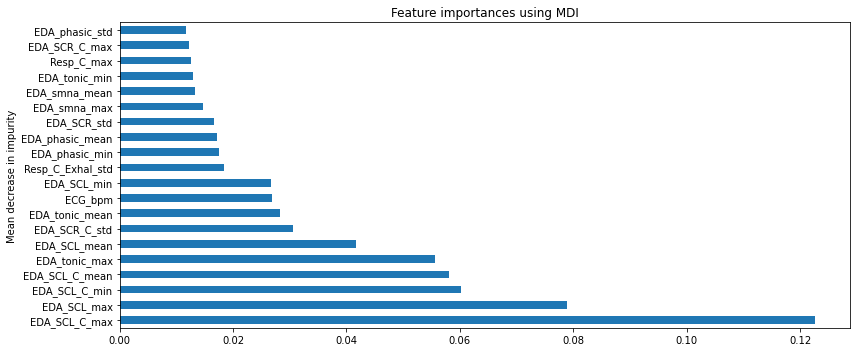

In [24]:
importances = classifier.feature_importances_
forest_importances = pd.Series(importances, index=features).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
forest_importances[:20].plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Support Vector Machine

In [462]:
# Create a SVC classifier using a linear kernel
clf = SVC(kernel='linear', C=1, random_state=0)
# Train the classifier
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_out = clf.predict(X_test)
lm_svc=(classification_report(y_test, y_out, digits=4))
print(lm_svc)

              precision    recall  f1-score   support

           0     0.5714    0.3721    0.4507        43
           1     0.7872    0.8810    0.8315       126
           2     0.8060    0.8060    0.8060        67

    accuracy                         0.7669       236
   macro avg     0.7215    0.6863    0.6960       236
weighted avg     0.7532    0.7669    0.7548       236



# Compare Results

Compare the results of the noisy data models and the clean data models

- Plots of SNR (x-axis) vs. accuracy (y-axis)
- Compare feature importances across different noise regimes
    - Develop dynamic evaluation method based on original feature importance / added noise

## Test Each Model Architecture

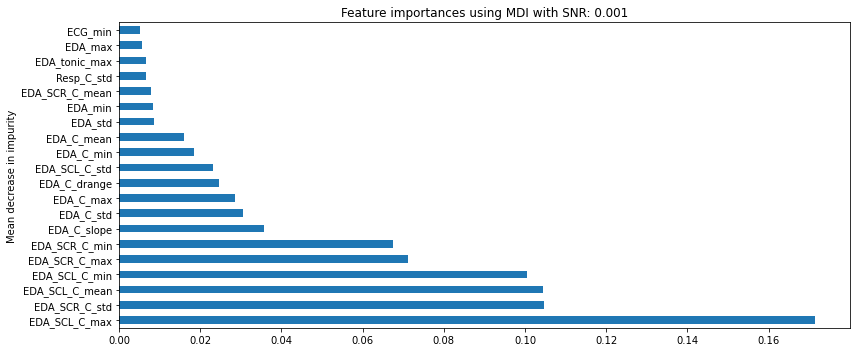

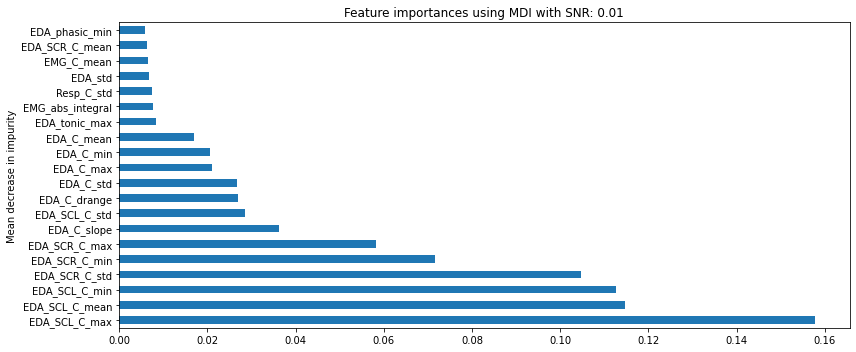

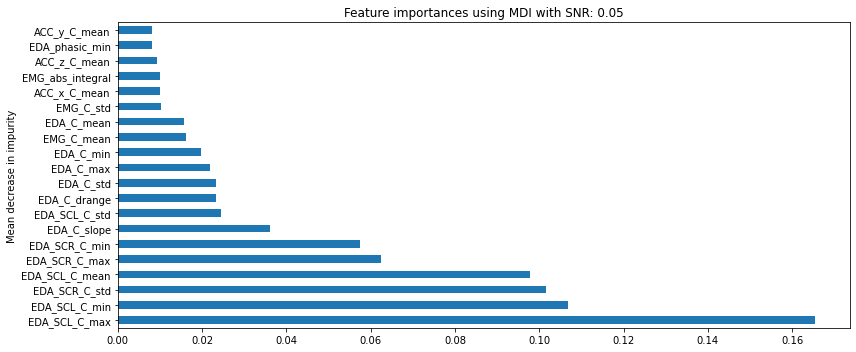

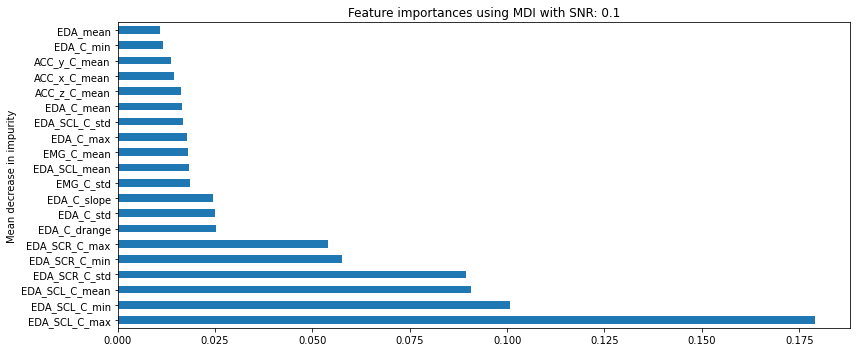

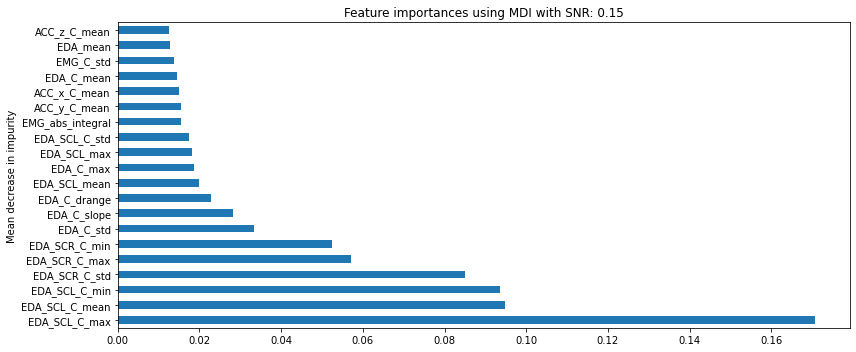

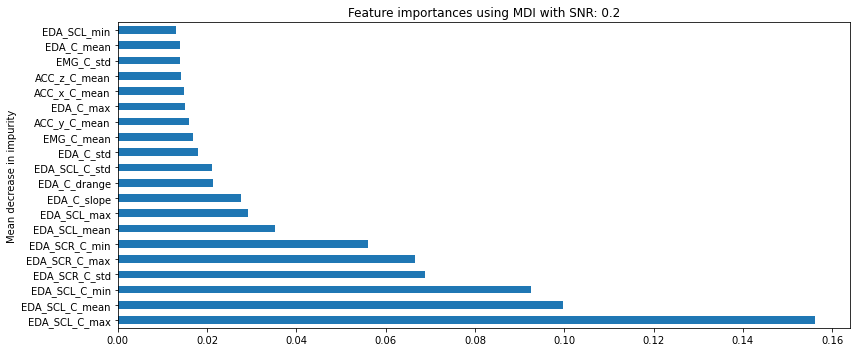

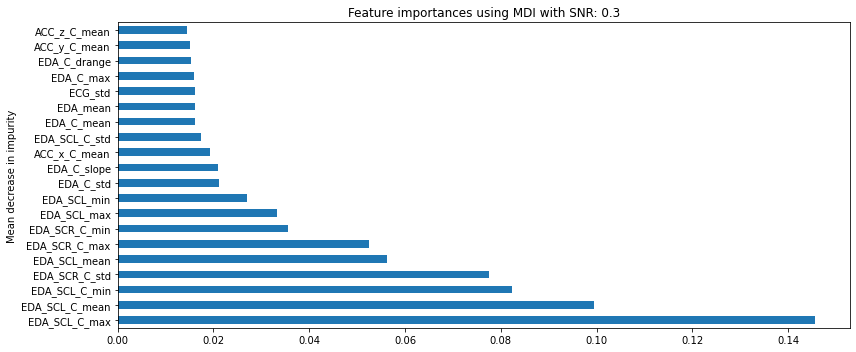

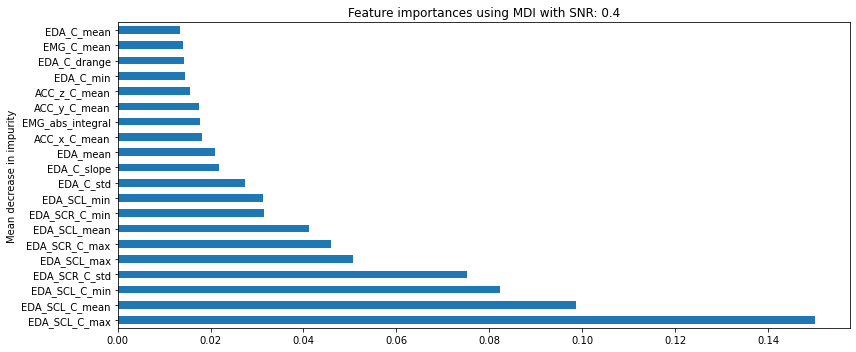

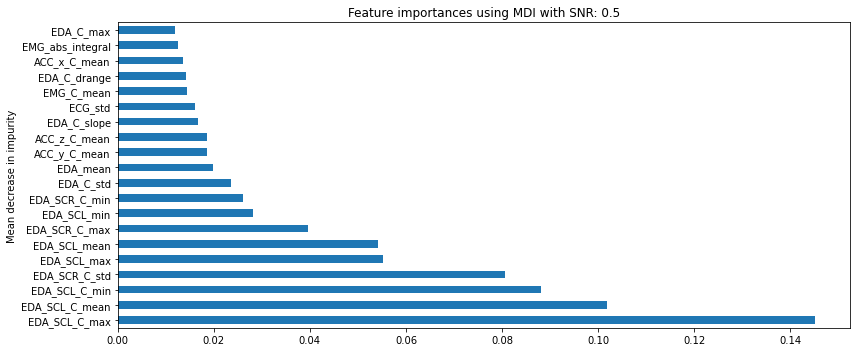

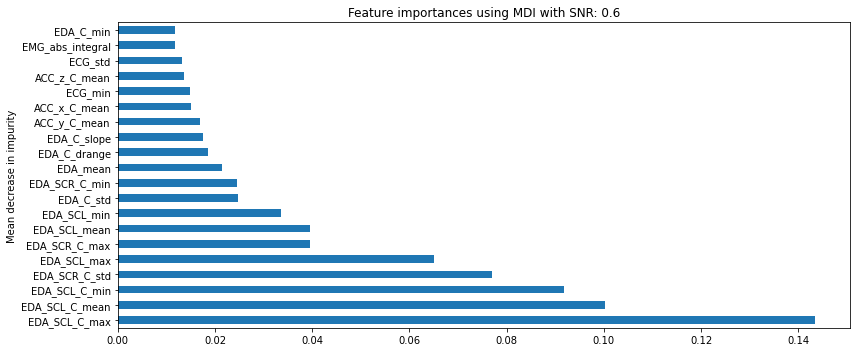

In [100]:
snrs = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6]
lda_accuracy = []
rf_accuracy = []
svm_accuracy = []
ft_imp_matrix = []
# For each signal to noise ratio
for i in range(len(snrs)):
    # Get data
    df = pd.read_csv('data/noise_snr_'+str(snrs[i])+'.csv', index_col=0)
    # Since Resp_C_rate is null for the first four, simply get rid of it
    df = df.loc[:, df.columns != 'Resp_C_rate']
    
    # Get features, label
    X = df.drop('label', axis=1).values
    y = df['label'].values

    # Get train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  
    
    # Scale the data
    sc = StandardScaler()  
    X_train = sc.fit_transform(X_train)  
    X_test = sc.transform(X_test)  
    
    # Test LDA
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    lda_accuracy.append(accuracy_score(y_test, y_pred))
    
    # Test RF
    classifier = RandomForestClassifier(max_depth=4, random_state=0)
    classifier.fit(X_train, y_train)  
    y_pred = classifier.predict(X_test)  
    rf_accuracy.append(accuracy_score(y_test, y_pred))
    importances = classifier.feature_importances_
    forest_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    ft_imp_matrix.append(importances)

    fig, ax = plt.subplots(figsize=(12, 5))
    forest_importances[:20].plot.barh(ax=ax)
    ax.set_title("Feature importances using MDI with SNR: " + str(snrs[i]))
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show();
    
    # Test SVM
    clf = SVC(kernel='linear', C=1, random_state=0)
    clf.fit(X_train, y_train)
    y_out = clf.predict(X_test)    
    svm_accuracy.append(accuracy_score(y_test, y_pred))

In [52]:
import scipy.stats as ss
for ft in range(0, len(ft_imp_matrix)):
    ft_imp_matrix[ft] = [sorted(ft_imp_matrix[ft], reverse=True).index(x) for x in ft_imp_matrix[ft]]

In [55]:
ft_imp_df = pd.DataFrame(ft_imp_matrix, columns=features)

In [56]:
ft_imp_df.head()

,net_acc_C_mean,net_acc_C_std,net_acc_C_min,net_acc_C_max,net_acc_mean,net_acc_std,net_acc_min,net_acc_max,EDA_mean,EDA_std,EDA_min,EDA_max,EDA_SCR_mean,EDA_SCR_std,EDA_SCR_min,EDA_SCR_max,EDA_SCL_mean,EDA_SCL_std,EDA_SCL_min,EDA_SCL_max,EDA_phasic_mean,EDA_phasic_std,EDA_phasic_min,EDA_phasic_max,EDA_smna_mean,EDA_smna_std,EDA_smna_min,EDA_smna_max,EDA_tonic_mean,EDA_tonic_std,EDA_tonic_min,EDA_tonic_max,BVP_mean,BVP_std,BVP_min,BVP_max,TEMP_mean,TEMP_std,TEMP_min,TEMP_max,ACC_x_mean,ACC_x_std,ACC_x_min,ACC_x_max,ACC_y_mean,ACC_y_std,ACC_y_min,ACC_y_max,ACC_z_mean,ACC_z_std,ACC_z_min,ACC_z_max,ECG_mean,ECG_std,ECG_min,ECG_max,EDA_C_mean,EDA_C_std,EDA_C_min,EDA_C_max,EDA_SCR_C_mean,EDA_SCR_C_std,EDA_SCR_C_min,EDA_SCR_C_max,EDA_SCL_C_mean,EDA_SCL_C_std,EDA_SCL_C_min,EDA_SCL_C_max,ACC_x_C_mean,ACC_x_C_std,ACC_x_C_min,ACC_x_C_max,ACC_y_C_mean,ACC_y_C_std,ACC_y_C_min,ACC_y_C_max,ACC_z_C_mean,ACC_z_C_std,ACC_z_C_min,ACC_z_C_max,EMG_C_mean,EMG_C_std,EMG_C_min,EMG_C_max,Resp_C_mean,Resp_C_std,Resp_C_min,Resp_C_max,Temp_C_mean,Temp_C_std,Temp_C_min,Temp_C_max,BVP_peak_freq,net_acc_abs_integral,ACC_x_abs_integral,ACC_y_abs_integral,ACC_z_abs_integral,net_acc_C_abs_integral,ACC_x_C_abs_integral,ACC_y_C_abs_integral,ACC_z_C_abs_integral,ACC_x_peak_freq,ACC_y_peak_freq,ACC_z_peak_freq,ACC_x_C_peak_freq,ACC_y_C_peak_freq,ACC_z_C_peak_freq,ECG_bpm,ECG_ibi,ECG_sdnn,ECG_sdsd,ECG_rmssd,ECG_pnn20,ECG_pnn50,EDA_slope,EDA_C_slope,EDA_drange,EDA_C_drange,EMG_drange,EMG_abs_integral,Resp_C_Inhal_mean,Resp_C_Inhal_std,Resp_C_Exhal_mean,Resp_C_Exhal_std,Resp_C_I/E,TEMP_drange,TEMP_C_drange,TEMP_slope,TEMP_C_slope,subject,age,height,weight,gender_ female,gender_ male,coffee_today_YES,sport_today_YES,smoker_NO,smoker_YES,feel_ill_today_YES
0,59,92,75,58,95,100,74,73,109,13,14,18,129,130,67,121,90,47,111,113,56,107,25,43,21,96,45,94,64,83,85,17,60,39,79,50,118,36,98,27,48,68,101,80,124,82,131,135,112,46,99,66,78,26,19,22,12,7,11,8,15,1,5,4,2,10,3,0,42,84,72,91,63,29,123,89,103,44,55,81,70,24,23,69,88,16,34,20,54,37,38,35,110,132,86,40,114,102,31,117,49,127,120,134,53,128,105,41,97,32,65,71,136,104,77,6,115,9,62,30,87,122,76,61,93,52,133,51,106,28,108,57,33,116,126,125,119,136,136,136
1,31,77,92,134,110,47,75,88,67,16,20,26,131,61,116,51,45,69,114,38,49,99,19,109,28,113,30,89,32,60,84,13,62,70,56,78,53,80,112,111,105,132,124,108,87,48,103,102,85,64,122,104,93,25,23,37,12,9,11,10,18,3,4,5,1,7,2,0,101,68,34,106,115,43,73,55,72,35,81,82,17,22,79,39,97,15,36,21,129,27,46,83,90,76,86,40,33,100,74,50,58,52,65,94,63,42,44,125,95,71,41,91,135,66,120,6,123,8,54,14,117,130,107,127,128,121,118,98,119,24,57,59,29,126,135,133,96,135,135,135
2,55,71,82,122,89,106,64,100,95,23,34,24,92,131,113,72,35,47,62,36,73,90,18,115,63,69,42,109,59,110,128,27,86,65,60,39,114,58,67,130,120,52,94,77,104,41,53,70,83,88,61,48,93,26,40,68,13,9,11,10,25,2,5,4,3,7,1,0,15,46,108,38,19,54,118,81,17,44,32,119,12,14,22,20,98,21,30,33,84,31,78,74,132,125,99,91,57,76,56,85,49,112,111,126,116,121,87,105,51,66,28,43,132,127,75,6,117,8,37,16,123,102,97,124,129,107,103,101,80,29,79,50,45,132,132,132,96,132,132,132
3,102,54,75,48,111,96,112,82,19,29,24,30,110,127,73,120,10,78,22,20,93,108,46,87,77,61,39,98,117,118,132,60,66,53,79,94,115,70,107,106,131,42,89,69,76,132,95,90,132,72,129,59,124,23,43,50,14,7,18,12,25,3,4,5,2,13,1,0,16,41,74,101,17,35,91,119,15,56,58,86,11,9,33,26,103,36,32,51,121,34,49,92,116,132,37,67,44,123,40,84,52,126,64,113,99,100,130,28,63,122,27,31,132,104,68,8,45,6,47,21,80,105,65,114,71,85,55,81,128,38,57,109,88,125,132,83,62,97,132,132
4,128,65,102,121,77,54,93,118,18,24,28,25,112,98,113,124,9,56,22,11,83,94,38,101,42,92,82,100,61,122,120,31,105,88,81,106,80,52,125,126,127,131,89,110,85,55,114,79,104,73,59,64,70,23,26,41,16,6,21,10,27,3,5,4,1,12,2,0,15,96,44,69,14,51,63,99,19,34,45,86,20,17,37,30,97,36,74,62,75,40,78,49,109,71,58,76,115,67,46,43,57,131,123,129,131,116,107,29,39,47,32,48,131,33,66,7,50,8,53,13,68,95,90,111,130,84,108,103,119,35,60,91,87,131,117,72,131,131,131,

In [66]:
ft_imp_df.columns.values

array(['net_acc_C_mean', 'net_acc_C_std', 'net_acc_C_min',
       'net_acc_C_max', 'net_acc_mean', 'net_acc_std', 'net_acc_min',
       'net_acc_max', 'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max',
       'EDA_SCR_mean', 'EDA_SCR_std', 'EDA_SCR_min', 'EDA_SCR_max',
       'EDA_SCL_mean', 'EDA_SCL_std', 'EDA_SCL_min', 'EDA_SCL_max',
       'EDA_phasic_mean', 'EDA_phasic_std', 'EDA_phasic_min',
       'EDA_phasic_max', 'EDA_smna_mean', 'EDA_smna_std', 'EDA_smna_min',
       'EDA_smna_max', 'EDA_tonic_mean', 'EDA_tonic_std', 'EDA_tonic_min',
       'EDA_tonic_max', 'BVP_mean', 'BVP_std', 'BVP_min', 'BVP_max',
       'TEMP_mean', 'TEMP_std', 'TEMP_min', 'TEMP_max', 'ACC_x_mean',
       'ACC_x_std', 'ACC_x_min', 'ACC_x_max', 'ACC_y_mean', 'ACC_y_std',
       'ACC_y_min', 'ACC_y_max', 'ACC_z_mean', 'ACC_z_std', 'ACC_z_min',
       'ACC_z_max', 'ECG_mean', 'ECG_std', 'ECG_min', 'ECG_max',
       'EDA_C_mean', 'EDA_C_std', 'EDA_C_min', 'EDA_C_max',
       'EDA_SCR_C_mean', 'EDA_SCR_C_std', 'EDA_

In [78]:
ft_imp_df.reset_index().pivot(index=ft_imp_df, columns=ft_imp_df.columns.values)

KeyError: 'index'

## Plot SNR vs. Accuracy

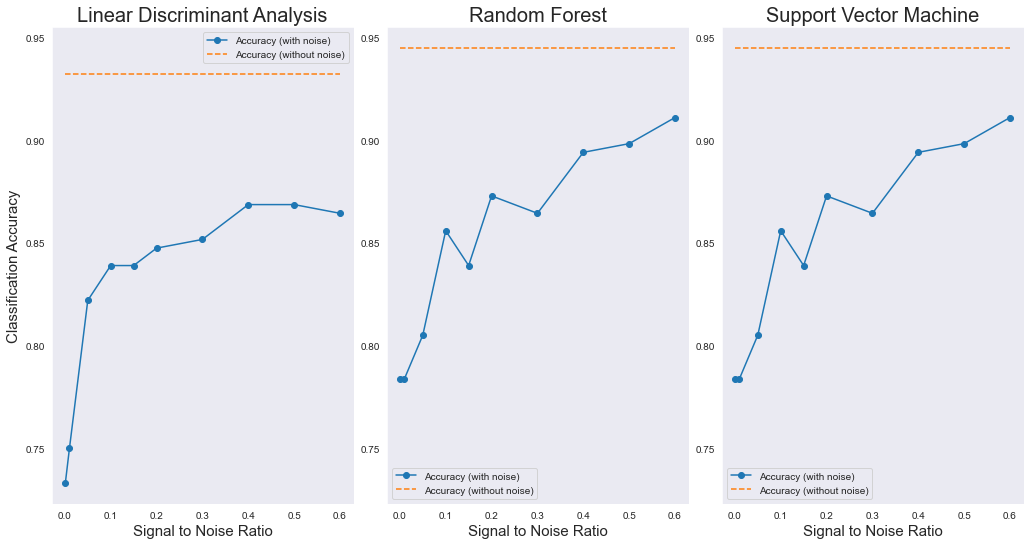

In [493]:
sns.set_style('dark')
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,7))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

min_accuracy = min(min(lda_accuracy), min(rf_accuracy), min(svm_accuracy)) - 0.01
max_accuracy = max(lda_baseline_acc, rf_baseline_acc, svm_baseline_acc) + 0.01

axs[0].plot(snrs, lda_accuracy, label='Accuracy (with noise)', marker='o');
axs[0].plot(snrs, [lda_baseline_acc]*len(snrs), linestyle='dashed', label='Accuracy (without noise)')
axs[0].set_title('Linear Discriminant Analysis', fontsize=20);
axs[0].set_xlabel('Signal to Noise Ratio', fontsize=15);
axs[0].set_ylabel('Classification Accuracy', fontsize=15);
axs[0].legend();
axs[0].set_ylim([min_accuracy, max_accuracy]);

axs[1].plot(snrs, rf_accuracy, label='Accuracy (with noise)', marker='o');
axs[1].plot(snrs, [rf_baseline_acc]*len(snrs), linestyle='dashed', label='Accuracy (without noise)')
axs[1].set_title('Random Forest', fontsize=20);
axs[1].set_xlabel('Signal to Noise Ratio', fontsize=15);
axs[1].legend();
axs[1].set_ylim([min_accuracy, max_accuracy]);

axs[2].plot(snrs, svm_accuracy, label='Accuracy (with noise)', marker='o');
axs[2].plot(snrs, [svm_baseline_acc]*len(snrs), linestyle='dashed', label='Accuracy (without noise)')
axs[2].set_title('Support Vector Machine', fontsize=20);
axs[2].set_xlabel('Signal to Noise Ratio', fontsize=15);
axs[2].legend();
axs[2].set_ylim([min_accuracy, max_accuracy]);